In [1]:
import os
import sys
from importlib import reload

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import torch
from torch.utils import data as D
# mixed precision
from apex import amp

# Local imports
sys.path.append('../src')
import dataset
import trainer
import models
import utils
import preprocessing
import mix
import transforms

# Transformers
import transformers
from transformers import XLMRobertaModel, XLMRobertaTokenizer, XLMRobertaConfig
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule

# Prediction analysis
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.special import softmax
from sklearn.calibration import calibration_curve

# Setup device
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Seed 
util.seed_everything()

print('use', device)

[nltk_data] Downloading package punkt to
[nltk_data]     /gpfs/hpc/home/papkov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
use cuda


# Full model training

In [2]:
reload(dataset)
reload(transforms)

<module 'transforms' from '../src/transforms.py'>

In [3]:
backbone_name = 'xlm-roberta-large'

## Datasets

In [4]:
from transformers import AutoTokenizer, XLMRobertaTokenizer, XLMRobertaConfig
tokenizer = AutoTokenizer.from_pretrained(backbone_name)

In [5]:
batch_size = 8
batch_size_val = 8
num_workers = 8
max_length = 256
# max_length = 512

In [6]:
util.seed_everything()
clean = False

valid = dataset.TokenizerDataset('../input/jigsaw_miltilingual_valid_translated.csv', max_length=max_length, 
                                 clean=clean,
                                 tokenizer=tokenizer, text_column='comment_text')
test = dataset.TokenizerDataset('../input/jigsaw_miltilingual_test_translated.csv', max_length=max_length,
                                clean=clean,
                                tokenizer=tokenizer, text_column='content')

train_transforms = [
#                     transforms.ShuffleSentences(p=0.5),
#                     transforms.PickRandomSentence(p=0.5),
#                     transforms.SwapWords(p=0.5, swap_p=0.1),
#                     transforms.DropWords(p=0.5, drop_p=0.05),
                    ]

# train = dataset.TokenizerDataset('../input/jigsaw-toxic-comment-train.csv', max_length=max_length,
#                                  tokenizer=tokenizer, transforms=train_transforms)
# train_ub = dataset.TokenizerDataset('../input/jigsaw-unintended-bias-train.csv', max_length=max_length, 
#                                     tokenizer=tokenizer, transforms=train_transforms)
# train = dataset.ConcatDataset([train, train_ub])

# train = dataset.MultilingualTrainTokenizerDataset(path_pattern='../input/multilingual-train-ludovick/jigsaw-toxic-comment-train_{}_clean.csv',
train = dataset.MultilingualTrainTokenizerDataset(path_pattern='../input/multilingual-train/jigsaw-toxic-comment-train-google-{}-cleaned.csv',
                                                  langs=['es', 'tr', 'ru', 'fr', 'it', 'pt', 'en'],
                                                  filter_bad=False,
                                                  filter_short=0,
                                                  lang_batch_sample=0,
#                                                   p_en=0.5,
#                                                   filter_long=1000,
                                                  clean=clean,
                                                  max_length=max_length, tokenizer=tokenizer, transforms=train_transforms)

# valid_ml = dataset.MultilingualTrainTokenizerDataset(path_pattern='../input/multilingual-train-ludovick/validation_{}.csv',
#                                                      langs=['es', 'tr', 'ru', 'fr', 'it', 'pt', 'en'],
#                                                      remove_lang=valid.dataset.lang,
#                                                      p_en=1/6,
#                                                      clean=True,
#                                                      max_length=max_length, tokenizer=tokenizer, transforms=train_transforms)
# train = dataset.ConcatDataset([train, valid_ml])
# train_ub = dataset.MultilingualTrainTokenizerDataset(path_pattern='../input/multilingual-train-ludovick/jigsaw-unintended-bias-train_{}_clean.csv',
#                                                      max_length=max_length, tokenizer=tokenizer, transforms=train_transforms)
# train = dataset.ConcatDataset([train, train_ub])

In [7]:
def worker_init_fn(worker_id):  
    """
    Sets different seed for each worker
    https://github.com/pytorch/pytorch/issues/5059
    """
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [8]:
loader_train = D.DataLoader(train, 
                            sampler=train.weighted_sampler(scale_factor=0.5, replacement=False), 
#                             worker_init_fn=worker_init_fn,
                            batch_size=batch_size, num_workers=num_workers)

# loader_train_ub = D.DataLoader(train_ub, 
#                             sampler=train_ub.weighted_sampler(scale_factor=0.2, replacement=False), 
#                             batch_size=batch_size, num_workers=num_workers)

loader_valid = D.DataLoader(valid, 
                            batch_size=batch_size_val, num_workers=num_workers)

loader_test = D.DataLoader(test, 
                           batch_size=batch_size_val, num_workers=num_workers)

len(loader_train), len(loader_valid), len(loader_test)

(2670, 1000, 7977)

## Models

In [9]:
reload(models)

<module 'models' from '../src/models.py'>

In [20]:
del model, backbone, head, optimizer

In [11]:
def convert_tf():
    from transformers import AutoConfig
    config = AutoConfig.from_pretrained(backbone_name)
    backbone = XLMRobertaModel.from_pretrained('../checkpoints/tf_model.h5', from_tf=True, config=config)
    torch.save(backbone.state_dict(), '../checkpoints/mlm_tf_6000.pth')

In [9]:
head = models.SimplePoolingHead(in_features=1024, mix=None, dropout=0.0, activation='tanh')
backbone = XLMRobertaModel.from_pretrained(backbone_name, output_hidden_states=False, num_labels=1)
model = models.Model(backbone=backbone, head=head, mix=None, mix_pos='sent', features=['cls'])
# model = models.Model(backbone=backbone, head=head, features=['cls'])

In [10]:
# Load pretrained head
#head_cp = '../checkpoints/simple_cls.pth'
#model.head.load_state_dict(torch.load(head_cp, map_location='cpu')['model'])

In [10]:
model.backbone.load_state_dict(torch.load('../checkpoints/mlm_tf_6000.pth', map_location='cpu'))

<All keys matched successfully>

In [49]:
# Freeze first BertLayers
# freeze_first = 4
# # model.backbone.embeddings.requires_grad_(False);
# for i in range(freeze_first):
#     model.backbone.encoder.layer[i].requires_grad_(False)
# print(f'Frozen first {freeze_first} out of {len(model.backbone.encoder.layer)}')

## Train

In [11]:
reload(trainer)
reload(mix)

<module 'mix' from '../src/mix.py'>

In [12]:
from torchcontrib.optim import SWA

In [14]:
# criterion = trainer.DiceDenseCrossEntropy(ce=0.75, dice=0.25)

# optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8, weight_decay=0)
optimizer = AdamW([{'params': model.head.parameters(), 'lr': 1e-3}, 
                  {'params': model.backbone.parameters()}],
                   lr=1e-5, eps=1e-8, weight_decay=0)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0)
# swa_opt = SWA(optimizer)
# scheduler = torch.optim.lr_scheduler.CyclicLR(swa_opt, 
#                                               base_lr=[1e-4, 1e-6], 
#                                               max_lr=[1e-3, 1e-5], 
#                                               step_size_up=3, #len(loader_train)/2/16, 
#                                               cycle_momentum=False)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=len(loader_train)//16)

# setattr(swa_opt, 'defaults', optimizer.defaults) # fix a bug with save

trnr = trainer.Trainer('roberta_simple_cls_multilingual_translated_1e-3_1e-5_wd=0_tanh_do=0_from_mlm_6000', model, 
                       loader_train, loader_valid, loader_test,
                       epochs=4,
                       monitor='val_auc',
                       optimizer=optimizer,
                       gradient_accumulation=16,
#                        num_warmup_steps=3,
#                        scheduler=scheduler,
#                        criterion=criterion,
#                        opt_level='O1',
                      )

In [15]:
trnr.fit()

valid: 100%|##########| 1000/1000 [02:16<00:00,  7.33it/s]


Epoch 0 complete. loss=0.3184, val_loss=0.2685, val_acc=0.8615, val_auc=0.9444
Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_1e-3_1e-5_wd=0_tanh_do=0_from_mlm_6000.pth


valid: 100%|##########| 1000/1000 [02:16<00:00,  7.34it/s]


Epoch 1 complete. loss=0.2181, val_loss=0.2620, val_acc=0.8696, val_auc=0.9457
Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_1e-3_1e-5_wd=0_tanh_do=0_from_mlm_6000.pth


valid: 100%|##########| 1000/1000 [02:16<00:00,  7.33it/s]


Epoch 2 complete. loss=0.2054, val_loss=0.2966, val_acc=0.8478, val_auc=0.9459
Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_1e-3_1e-5_wd=0_tanh_do=0_from_mlm_6000.pth


valid: 100%|##########| 1000/1000 [02:16<00:00,  7.33it/s]


Epoch 3 complete. loss=0.1995, val_loss=0.2843, val_acc=0.8595, val_auc=0.9466
Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_1e-3_1e-5_wd=0_tanh_do=0_from_mlm_6000.pth


In [ ]:
trnr.reset_scheduler()
trnr.fit()

ep. 0000:  53%|#####2    | 1412/2670 [09:28<08:29,  2.47it/s, loss=0.229, acc=0.906, lr=8.68e-6]

## Validate

In [4]:
#state = torch.load('../checkpoints/roberta_simple_cls_multilingual_translated_2e-5_tanh_do=0_no_worker_init_no_reinit_old_sampling.pth', map_location='cpu')

In [16]:
trnr.load_checkpoint()

Loaded model from ../checkpoints//roberta_simple_cls_multilingual_translated_1e-3_1e-5_wd=0_tanh_do=0_from_mlm_uncleaned_cosine.pth
epoch 2, loss: 0.2160 val_loss: 0.2804 val_acc: 0.8600 val_auc: 0.9456 


In [67]:
reload(dataset)

<module 'dataset' from '../src/dataset.py'>

In [9]:
trnr.load_checkpoint('../checkpoints/roberta_simple_cls_multilingual_translated_2e-5_ga=16_do=0_tanh.pth')

ep. 0002:  21%|##        | 548/2670 [04:47<14:19,  2.47it/s, loss=0.207, acc=0.916, lr=1.12e-5]

Loaded model from ../checkpoints/roberta_simple_cls_multilingual_translated_2e-5_ga=16_do=0_tanh.pth
epoch 1, loss: 0.2062 val_loss: 0.2561 val_acc: 0.8759 val_auc: 0.9461 


In [24]:
print(reload(preprocessing))
print(reload(dataset))
valid = dataset.TokenizerDataset('../input/jigsaw_miltilingual_valid_translated.csv', max_length=512, 
                                 tokenizer=tokenizer, text_column='comment_text')
# valid = dataset.Dataset('../input/validation.npz')
loader_valid = D.DataLoader(valid, batch_size=batch_size_val, num_workers=num_workers)

[nltk_data] Downloading package punkt to
[nltk_data]     /gpfs/hpc/home/papkov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
<module 'preprocessing' from '../src/preprocessing.py'>
<module 'dataset' from '../src/dataset.py'>


In [21]:
# 256
pred, loss, acc, auc = trnr.predict(loader=loader_valid)
auc, acc, loss

predict: 100%|##########| 1000/1000 [02:17<00:00,  7.30it/s]


(0.9490025338953535, 0.862625, 0.27622192503511905)

In [15]:
# 256
pred, loss, acc, auc = trnr.predict(loader=loader_valid)
auc, acc, loss

predict: 100%|##########| 1000/1000 [02:16<00:00,  7.30it/s]


(0.9429217854955506, 0.8695, 0.2694804871231318)

In [25]:
# 512
pred, loss, acc, auc = trnr.predict(loader=loader_valid)
auc, acc, loss

predict: 100%|##########| 1000/1000 [04:35<00:00,  3.62it/s]


(0.9450920488525417, 0.868375, 0.2564316531121731)

In [45]:
reload(transforms)

<module 'transforms' from '../src/transforms.py'>

In [37]:
valid_last_sent = dataset.TokenizerDataset('../input/jigsaw_miltilingual_valid_translated.csv', max_length=max_length,
                                           tokenizer=tokenizer, text_column='comment_text',
                                           transforms=[transforms.PickLastSentence(p=1)])
loader_valid_last_sent = D.DataLoader(valid_last_sent, batch_size=batch_size_val, num_workers=num_workers)

In [38]:
pred_last, loss, acc, auc = trnr.predict(loader_valid_last_sent)
auc, acc, loss

predict:  76%|#######6  | 760/1000 [01:43<00:32,  7.32it/s]

<class 'transforms.PickLastSentence'> was failed to apply to [] due to [list index out of range]


predict: 100%|##########| 1000/1000 [02:16<00:00,  7.34it/s]


(0.7752584333081145, 0.82325, 0.4869999413564801)

In [58]:
valid.text_column='translated'

In [59]:
pred_translated, loss, acc, auc = trnr.predict(loader=loader_valid)
auc, acc, loss

predict: 100%|##########| 1000/1000 [02:16<00:00,  7.30it/s]


(0.9310278488309256, 0.879375, 0.260242011398077)

In [16]:
smpred = softmax(pred / 1, 1)[:,1]
smpred[:5]

array([0.6461915 , 0.0961536 , 0.94487524, 0.01293857, 0.01563411],
      dtype=float32)

In [82]:
smpred_prev = softmax(pred / 1, 1)[:,1]
smpred_prev[:5]

array([0.46674946, 0.052074  , 0.91198564, 0.04765975, 0.05153814],
      dtype=float32)

In [64]:
smpred_last = softmax(pred_last / 1, 1)[:,1]
smpred_last[:5]

array([0.14376275, 0.01694615, 0.96574783, 0.02020077, 0.07131837],
      dtype=float32)

In [61]:
smpred_translated = softmax(pred_translated / 1, 1)[:,1]
smpred_translated[:5]

array([3.8540781e-01, 3.4235546e-04, 8.4419376e-01, 1.8401514e-06,
       2.3138556e-03], dtype=float32)

In [17]:
def prediction_analysis(smpred):
    acc = accuracy_score(valid.y, np.round(smpred))
    auc = roc_auc_score(valid.y, smpred)
    print(f'    acc {acc:.4f}, auc {auc:.4f}\n')

    for lang in ['es', 'it', 'tr']:
        mask = valid.dataset['lang'] == lang
        acc = accuracy_score(valid.y[mask], np.round(smpred[mask]))
        auc = roc_auc_score(valid.y[mask], smpred[mask])
        print(f'{lang}: acc {acc:.4f}, auc {auc:.4f}')
        
    fig, ax = plt.subplots(ncols=2, figsize=(7,3))
    
    ax[0].set_title('Score distribution')
    sns.distplot(smpred[valid.y == 0], ax=ax[0], label='non-toxic')
    sns.distplot(smpred[valid.y == 1], ax=ax[0], label='toxic')
    ax[0].legend()
    
    ax[1].set_title('Calibration plot')
    ax[1].plot(*calibration_curve(valid.y, smpred), 's-')
    plt.show()

In [18]:
def minmax_scaling(smpred):
    mi = smpred.min()
    ma = smpred.max()
    return (smpred-mi) / (ma-mi)

In [86]:
smpred_rounded = smpred.copy()
smpred_rounded[smpred_rounded < 0.01] = 0
smpred_rounded[smpred_rounded > 0.99] = 1

    acc 0.8686, auc 0.9450

es: acc 0.8212, auc 0.9307
it: acc 0.8020, auc 0.9093
tr: acc 0.9637, auc 0.9860


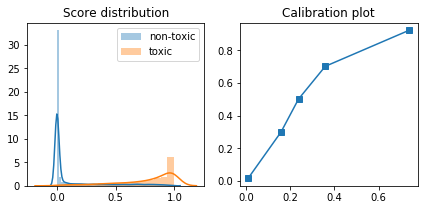

In [64]:
prediction_analysis(smpred)

    acc 0.8759, auc 0.9461

es: acc 0.8308, auc 0.9321
it: acc 0.8152, auc 0.9104
tr: acc 0.9640, auc 0.9858


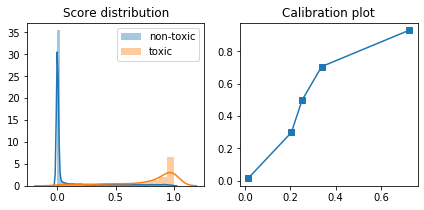

In [13]:
prediction_analysis(smpred)

    acc 0.8695, auc 0.9429

es: acc 0.8232, auc 0.9287
it: acc 0.8060, auc 0.9086
tr: acc 0.9610, auc 0.9847


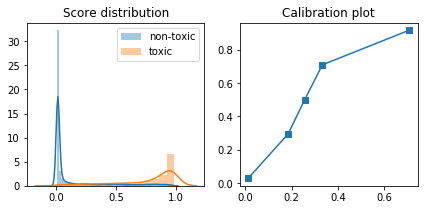

In [19]:
prediction_analysis(smpred)

    acc 0.8626, auc 0.9490

es: acc 0.8148, auc 0.9365
it: acc 0.7884, auc 0.9182
tr: acc 0.9643, auc 0.9870


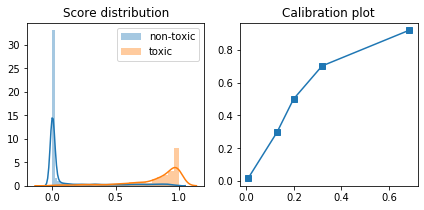

In [25]:
# with translated val
prediction_analysis(smpred)

    acc 0.8686, auc 0.9442

es: acc 0.8212, auc 0.9294
it: acc 0.8020, auc 0.9092
tr: acc 0.9637, auc 0.9839


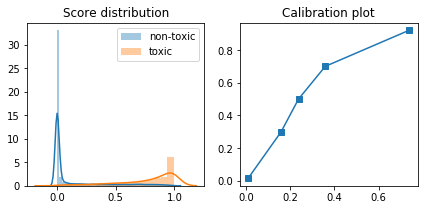

In [87]:
prediction_analysis(smpred_rounded)

    acc 0.8490, auc 0.9399

es: acc 0.7964, auc 0.9273
it: acc 0.7744, auc 0.9000
tr: acc 0.9550, auc 0.9824


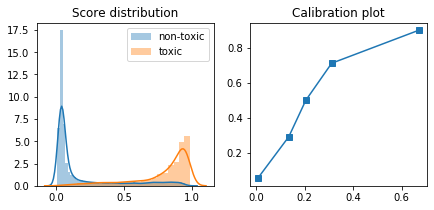

In [85]:
prediction_analysis(smpred_prev)

    acc 0.8744, auc 0.9275

es: acc 0.8368, auc 0.9086
it: acc 0.8180, auc 0.8834
tr: acc 0.9527, auc 0.9730


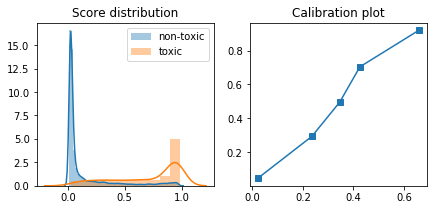

In [66]:
prediction_analysis(smpred_last)

    acc 0.8794, auc 0.9310

es: acc 0.8444, auc 0.9167
it: acc 0.8288, auc 0.8902
tr: acc 0.9507, auc 0.9821


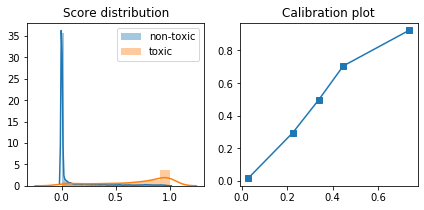

In [65]:
prediction_analysis(smpred_translated)

    acc 0.8691, auc 0.9453

es: acc 0.8208, auc 0.9306
it: acc 0.8036, auc 0.9098
tr: acc 0.9640, auc 0.9864


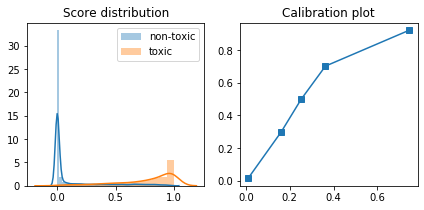

In [73]:
alpha = 0.95
prediction_analysis(smpred_translated * (1-alpha) + smpred * alpha )

## Pseudolabeling on val data

In [25]:
reload(dataset)

<module 'dataset' from '../src/dataset.py'>

In [57]:
valid_pseudo = dataset.PseudolabelDataset(scores=smpred, threshold=0.95, 
                                          fn='../input/jigsaw_miltilingual_valid_translated.csv', 
                                          max_length=max_length,
                                          tokenizer=tokenizer, text_column='comment_text',
                                          transforms=train_transforms)

Use 4216 rows for pseudolabels from 8000


In [58]:
loader_valid_pseudo = D.DataLoader(valid_pseudo, 
                                   sampler=valid_pseudo.weighted_sampler(),
                                   batch_size=batch_size_val, num_workers=num_workers)
len(loader_valid_pseudo)

75

In [59]:
optimizer = AdamW(model.parameters(), lr=1e-6, eps=1e-8)

trnr = trainer.Trainer('roberta_simple_cls_freeze_4_pseudo_val_2', model, 
                       loader_valid_pseudo, loader_valid, loader_test,
                       epochs=4,
                       monitor='val_auc',
                       optimizer=optimizer,
                       gradient_accumulation=4
                      )

In [62]:
trnr.load_checkpoint('../checkpoints/roberta_simple_cls_freeze_4_pseudo_val.pth')
trnr.reset_scheduler()
trnr.scheduler.get_last_lr()

ep. 0000:   0%|          | 0/75 [00:46<?, ?it/s, acc=0, loss=0, lr=5e-6]cc=0.75, lr=4.95e-6]]]e-6]

Loaded model from ../checkpoints/roberta_simple_cls_freeze_4_pseudo_val.pth
epoch 1, loss: 0.4357 val_loss: 0.2650 val_acc: 0.8736 val_auc: 0.9628 


[5e-06]

In [ ]:
trnr.fit()

## Fine-tuning on val

In [9]:
loader_valid_ml = D.DataLoader(valid_ml, 
                               sampler=valid_ml.weighted_sampler(scale_factor=1, replacement=False), 
                               batch_size=batch_size, num_workers=num_workers)
len(loader_valid_ml)

308

In [10]:
optimizer = AdamW(model.parameters(), lr=5e-6, eps=1e-8, weight_decay=0)

trnr = trainer.Trainer('roberta_simple_cls_multilingual_translated_2e-5_ga=16_do=0_tanh_on_val_4_5e-6', model, 
                       loader_valid_ml, loader_valid, loader_test,
                       epochs=4,
                       monitor='val_auc',
                       optimizer=optimizer,
                       gradient_accumulation=16
                      )

In [11]:
trnr.load_checkpoint('../checkpoints/roberta_simple_cls_multilingual_translated_2e-5_ga=16_do=0_tanh.pth', 
                     ignore=['optimizer', 'scheduler'])

Loaded model from ../checkpoints/roberta_simple_cls_multilingual_translated_2e-5_ga=16_do=0_tanh.pth
epoch 1, loss: 0.2062 val_loss: 0.2561 val_acc: 0.8759 val_auc: 0.9461 


In [12]:
trnr.fit()

valid: 100%|##########| 1000/1000 [02:17<00:00,  7.29it/s]


Epoch 0 complete. loss=0.3563, val_loss=0.2700, val_acc=0.8448, val_auc=0.9468
Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_2e-5_ga=16_do=0_tanh_on_val_4_5e-6.pth


valid: 100%|##########| 1000/1000 [02:17<00:00,  7.29it/s]


Epoch 1 complete. loss=0.3204, val_loss=0.2521, val_acc=0.8548, val_auc=0.9487
Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_2e-5_ga=16_do=0_tanh_on_val_4_5e-6.pth


valid: 100%|##########| 1000/1000 [02:17<00:00,  7.28it/s]


Epoch 2 complete. loss=0.3142, val_loss=0.2810, val_acc=0.8405, val_auc=0.9507
Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_2e-5_ga=16_do=0_tanh_on_val_4_5e-6.pth


valid: 100%|##########| 1000/1000 [02:17<00:00,  7.27it/s]


Epoch 3 complete. loss=0.2996, val_loss=0.2771, val_acc=0.8450, val_auc=0.9513
Saved model to ../checkpoints//roberta_simple_cls_multilingual_translated_2e-5_ga=16_do=0_tanh_on_val_4_5e-6.pth


Test

In [26]:
pred_test, loss_test, acc_test, auc_test = trnr.test()

test: 100%|##########| 7977/7977 [18:17<00:00,  7.27it/s]


In [27]:
sub = pd.read_csv('../input/sample_submission.csv')
sub.toxic = softmax(pred_test / 1, 1)[:,1]
sub.to_csv('../submissions/submission_multilingual_with_valid_ml.csv', index=False)

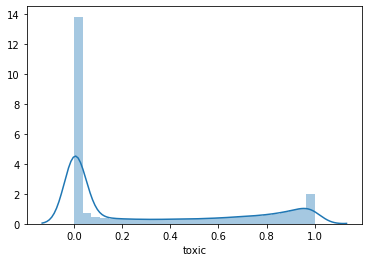

In [28]:
sns.distplot(sub.toxic)